In [1]:
# Reinforcement Learning using Q-learn
%matplotlib inline
import pandas_datareader as pdr
import tensorflow as tf
import numpy as np
import random
import pandas as pd

In [5]:
def get_prices(share_symbol, start_date=None, end_date=None):
        if start_date:
            stock_prices_list = pdr.get_data_fred(share_symbol, start_date, end_date)
        else:
            stock_prices_list = pdr.get_data_fred(share_symbol)
        stock_prices = list()
        for stock_price in stock_prices_list.GS10:
            stock_prices.append(stock_price)
        return stock_prices


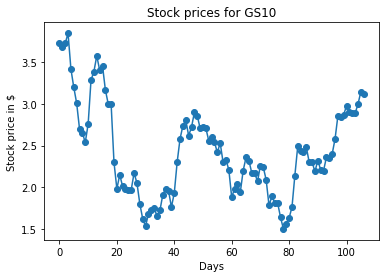

In [6]:
stock_prices = get_prices('GS10')
index = range(len(stock_prices))
import matplotlib.pyplot as plt
plt.title("Stock prices for GS10")
plt.xlabel("Days")
plt.ylabel("Stock price in $")
plt.scatter(index, stock_prices)
plt.plot(index, stock_prices)
plt.show()


In [7]:
class DecisionPolicy:
    
    def select_action(self, current_state, step):
        pass
        
    def update_q(self, state, action, reward, next_state):
        pass


In [8]:
class RandomDecisionPolicy(DecisionPolicy):
    
    def __init__(self, actions):
        self.actions = actions
        
    def select_action(self, current_state, step):
        return random.choice(self.actions)


In [9]:

def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        # if i % 10 == 0:
        #     print('progress {:.2f}'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i+hist])
        if action == 'Buy' and share_value < budget:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            num_stocks -= 1
            budget += share_value
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+1+hist], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state, next_state))
        policy.update_q(current_state, action, reward, next_state)
        
    portfolio = budget + num_stocks * share_value
    return portfolio


In [10]:
def run_simulations(policy, initial_budget, initial_num_stocks, prices, hist):
    portfolios = []
    num_tries = 10
    for t in range(num_tries):
        portfolios.append(run_simulation(policy, initial_budget, initial_num_stocks, prices, hist))
    plt.title("Portfolios simulated")
    plt.ylabel("Portfolio value calculated")
    plt.xlabel("Simulations")
    plt.scatter(range(num_tries), portfolios)
    plt.plot(range(num_tries), portfolios)
    

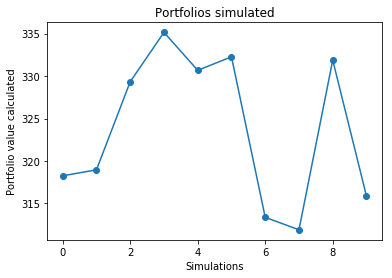

In [11]:
run_simulations(RandomDecisionPolicy(['Buy', 'Sell', 'Hold']), 10.0, 100, stock_prices, 3)






In [12]:
class QLearningDecisionPolicy(DecisionPolicy):
    
    def __init__(self, actions, input_dim):
        self.actions = actions
        self.epsilon = 0.95
        self.gamma = 0.3
        output_dim = len(actions)
        h1_dim = 20
        
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        
        self.W1 = tf.Variable(tf.random.normal(shape=[input_dim, h1_dim]))
        self.b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, self.W1) + self.b1)
        self.W2 = tf.Variable(tf.random.normal(shape=[h1_dim, output_dim]))
        self.b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        
        loss = tf.square(self.y-self.q)
        self.train = tf.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step/100)
        if random.random() < threshold:
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)
            return self.actions[action_idx]
        else:
            return self.actions[random.randint(0, len(self.actions)-1)]
        
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train, feed_dict={self.x: state, self.y: action_q_vals})


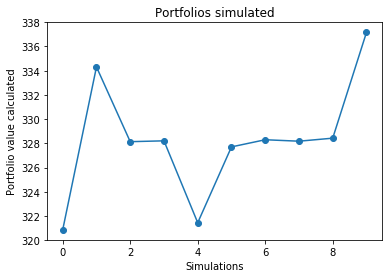

In [14]:
run_simulations(QLearningDecisionPolicy(['Buy', 'Sell', 'Hold'], 5), 10.0, 100, stock_prices, 3)